In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [58]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [183]:


# Please make sure that the desired set of settings has been calculated
def settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee,df_p): 
    target_df = settings_to_target_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee)
    df_p.index = target_df.index
    
    df_p = df_p.copy()

    if pricing_type == "constant": # we are calculating for constant pricing an average price weighted by the grid power draw
        weights = target_df.applymap(lambda x: 0 if x < 0 else x).sum(axis=1)
        weighted_average = np.average(df_p["Deutschland/Luxemburg [€/kWh]"], weights=weights)
        df_p["Deutschland/Luxemburg [€/kWh]"]  = weighted_average
        

    target_df_costs = target_df.copy()

    for col in target_df.columns:
        for idx in target_df.index:
            if target_df[col][idx] < 0:
                target_df_costs[col][idx] = target_df[col][idx] * feed_in_tariff
            else:
                target_df_costs[col][idx] = target_df[col][idx] * (df_p["Deutschland/Luxemburg [€/kWh]"][idx]+grid_charges+handling_fee)
    return target_df_costs


def settings_to_target_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee):
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{str(feed_in_tariff)}_ne_{str(grid_charges).replace('.','')}.pkl")
    return target_df



In [184]:

feed_in_tariff = 0.07
grid_charges = 0.072
handling_fee = 0.02

pricing_type = "constant"
operation_type = "constant"

constant = settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee,df_p)
constant

,158,262,458,348,356,136,211,236,166,333,...,291,137,400,196,307,361,199,234,193,459
2019-01-01 00:00:00+00:00,0.341867,1.060803,1.493826,0.655974,0.678695,1.107218,0.428455,1.070462,1.134165,0.887529,...,0.166507,0.144632,0.151606,0.2694,0.107774,0.138696,0.166856,0.162336,0.141161,0.075269
2019-01-01 01:00:00+00:00,0.692747,1.028922,1.274731,0.751587,0.822395,0.820273,0.996088,1.090097,1.654531,0.944164,...,0.159953,0.142504,0.154215,0.148264,0.100739,0.144569,0.164796,0.189764,0.148952,0.237951
2019-01-01 02:00:00+00:00,0.620467,1.148966,1.299196,0.986002,0.606091,1.201726,0.517007,1.208493,0.873598,0.963632,...,0.151628,0.143601,0.164619,0.151728,0.121061,0.166087,0.167924,0.261535,0.146798,0.100506
2019-01-01 03:00:00+00:00,0.421467,1.316104,1.441185,0.950203,0.875792,1.165441,0.799716,1.231563,0.779888,0.97535,...,0.147801,0.143072,0.169229,0.147275,0.118065,0.152352,0.164927,0.149127,0.146202,0.096906
2019-01-01 04:00:00+00:00,0.515695,0.947182,1.312018,1.011174,0.628485,1.036316,1.047211,1.031726,1.493885,0.970762,...,0.185758,0.143693,0.302471,0.149294,0.118042,0.141764,0.323283,0.158859,0.146592,0.104915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,1.134593,0.491276,1.618283,1.566998,1.335207,0.878521,1.22142,0.665901,0.784174,0.952656,...,0.166811,0.1621,0.129536,0.149192,0.596953,0.242337,0.186147,0.171998,0.318697,0.201939
2019-12-31 20:00:00+00:00,1.075571,0.604226,0.935223,1.206918,1.369613,0.806399,1.132795,1.323318,0.789748,0.938531,...,0.141184,0.168815,0.130628,0.03379,0.173268,0.142573,0.167124,0.164443,0.190453,0.057649
2019-12-31 21:00:00+00:00,1.153258,0.750918,1.237596,1.441697,1.758616,0.963842,1.351373,0.938904,0.800258,1.143554,...,0.144647,0.144695,0.11804,0.086589,0.360607,0.139017,0.189087,0.175001,0.154603,0.094248
2019-12-31 22:00:00+00:00,0.909766,0.915983,1.019232,1.404705,0.776646,1.015048,0.675578,0.681855,1.025854,1.025172,...,0.147268,0.149989,0.108665,0.093318,0.312292,0.13677,0.184106,0.164609,0.159442,0.11272


In [185]:

pricing_type = "dynamic"
operation_type = "dynamic"

dynamic = settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee,df_p)

<AxesSubplot: >

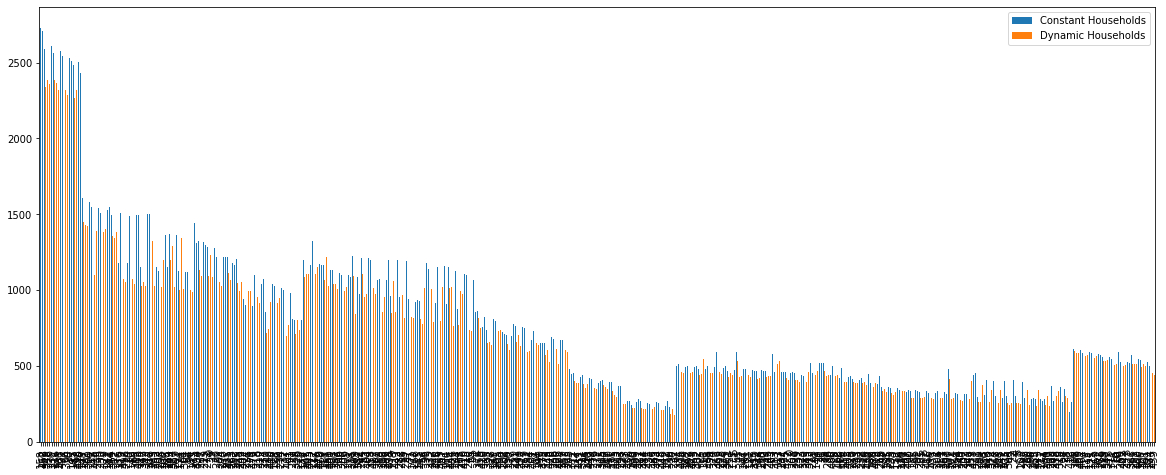

In [186]:
comparison = pd.DataFrame()

comparison["Constant Households"] = constant.sum()
comparison["Dynamic Households"] = dynamic.sum()

comparison.plot.bar(figsize=(20,8))



In [187]:
comparison

,Constant Households,Dynamic Households
158,2732.137113,2525.744935
262,2710.006739,2497.894196
458,2588.463304,2341.427597
348,2590.325587,2386.538685
356,2583.851228,2357.430661
...,...,...
361,531.354077,500.039853
199,523.546876,499.963897
234,498.830937,442.447663
193,498.268363,454.217909


<AxesSubplot: >

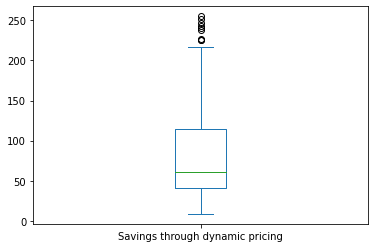

In [192]:
# plotting savings through dynamic operation
comparison["Savings through dynamic pricing"] = comparison["Constant Households"] - comparison["Dynamic Households"]
comparison["Savings through dynamic pricing"].plot.box()


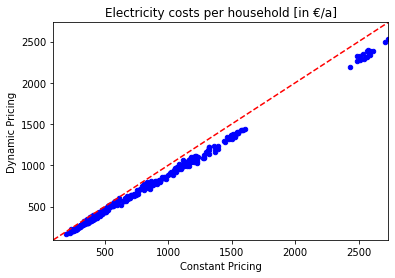

In [193]:
# drawing on one axis the constant costs, on the other
df = comparison

fig, ax = plt.subplots()
max_value = max(df['Constant Households'].max(), df['Constant Households'].max())
min_value = min(df['Constant Households'].min(), df['Constant Households'].min())
df.plot(kind='scatter', x='Constant Households', y='Dynamic Households', ax=ax, color='blue')

ax.plot([min_value-100, max_value], [min_value-100, max_value], 'r--')#drawing a diagonal line
ax.set_xlim([min_value-100, max_value])
ax.set_ylim([min_value-100, max_value])

plt.xlabel('Constant Pricing')
plt.ylabel('Dynamic Pricing')
plt.title('Electricity costs per household [in €/a]')

plt.show()

In [194]:
# investigating aggregated loads on highest feed-in and highest heat pump days
pricing_type = "constant"
operation_type = "constant"

constant_df = settings_to_target_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee)


pricing_type = "dynamic"
operation_type = "dynamic"

dynamic_df = settings_to_target_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee)


In [195]:
constant_df.sum(axis=1).max()

927.6350956614543

In [196]:
heat_pump_peak = '2019-12-01'
compare_df = pd.DataFrame()
compare_df.index = constant_df.loc[heat_pump_peak].index
compare_df["Constant"] = constant_df.loc[heat_pump_peak].sum(axis=1).values
compare_df["Dynamic"] = dynamic_df.loc[heat_pump_peak].sum(axis=1).values
compare_df["Price"] = df_p.loc[heat_pump_peak].values


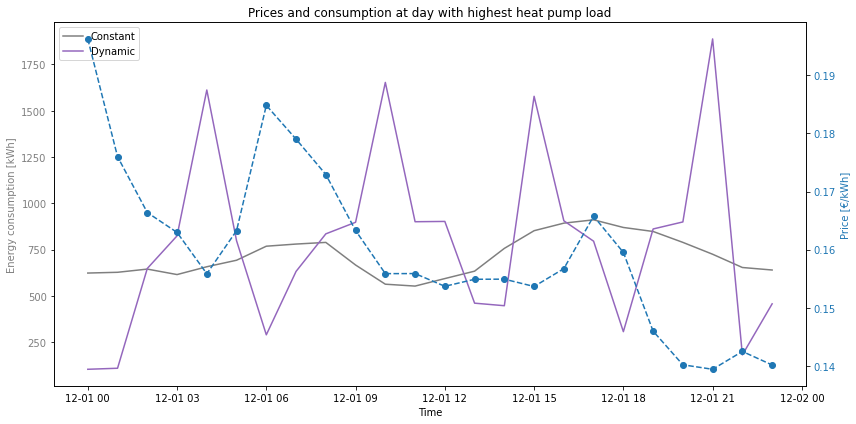

In [197]:
fig, ax1 = plt.subplots()

color1 = 'tab:grey'
color2 = 'tab:purple'
ax1.set_title("Prices and consumption at day with highest heat pump load")

ax1.set_xlabel('Time')
ax1.set_ylabel('Energy consumption [kWh]', color=color1)
ax1.plot(compare_df.index, compare_df["Constant"].values, color=color1, label='Constant')
ax1.plot(compare_df.index, compare_df["Dynamic"].values, color=color2, label='Dynamic')

ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Price [€/kWh]', color=color3)
ax2.plot(compare_df.index, compare_df["Price"].values, color=color3, marker='o', linestyle='--',)
ax2.tick_params(axis='y', labelcolor=color3,)

fig.set_size_inches(12,6)
fig.tight_layout()  # for a neat layout

plt.show()




In [167]:
pv_peak = '2019-05-13'
compare_df = pd.DataFrame()
compare_df.index = constant_df.loc[pv_peak].index
compare_df["Constant"] = constant_df.loc[pv_peak].sum(axis=1).values
compare_df["Dynamic"] = dynamic_df.loc[pv_peak].sum(axis=1).values
compare_df["Price"] = df_p.loc[pv_peak].values


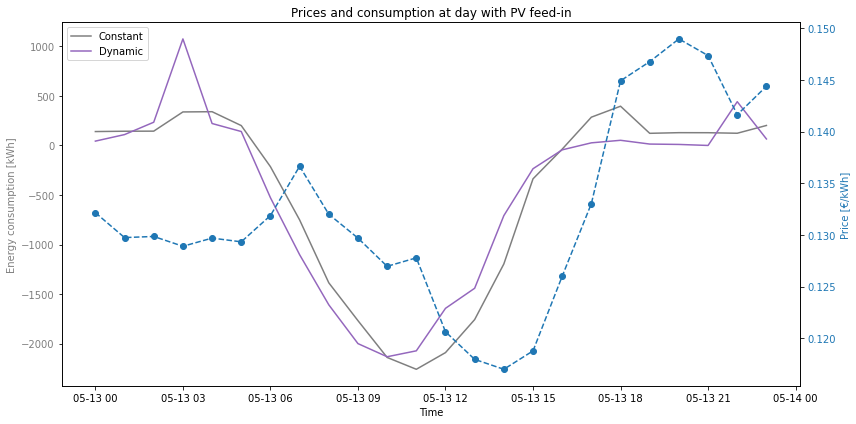

In [168]:
fig, ax1 = plt.subplots()

color1 = 'tab:grey'
color2 = 'tab:purple'
ax1.set_title("Prices and consumption at day with PV feed-in")

ax1.set_xlabel('Time')
ax1.set_ylabel('Energy consumption [kWh]', color=color1)
ax1.plot(compare_df.index, compare_df["Constant"].values, color=color1, label='Constant')
ax1.plot(compare_df.index, compare_df["Dynamic"].values, color=color2, label='Dynamic')

ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color3 = 'tab:blue'
ax2.set_ylabel('Price [€/kWh]', color=color3)
ax2.plot(compare_df.index, compare_df["Price"].values, color=color3, marker='o', linestyle='--',)
ax2.tick_params(axis='y', labelcolor=color3,)

fig.set_size_inches(12,6)
fig.tight_layout()  # for a neat layout

plt.show()


